# Stating the problem

We want to develop a regime based asset allocation method, therefore we have to:
1. Use an algorithm for regimes identification
2. Smooth the output to avoid "false crashes"
3. Optimize for each scenario
4. Backtest 

In order to complete these tasks we will use these models:
1. Hidden Markov Model
2. Trend Filtering algorithm
3. Mean Variance optimization
4. Simple backtest with perfect capital market assumptions

# 0. Setup

In [1]:
import pandas as pd
import matplotlib.pyplot   as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
from hmmlearn import hmm
import cvxpy as cp

import riskfolio as rp

import warnings

warnings.filterwarnings('ignore')

In [2]:
tickers=['SPY','SHY','GLD','TLT','TIP']
tickers.sort()

data=yf.download(tickers,interval='1d')['Adj Close'].dropna()

[*********************100%***********************]  5 of 5 completed


In [3]:
data

,GLD,SHY,SPY,TIP,TLT
Date,,,,,
2004-11-18,44.380001,61.547691,84.126633,59.913052,50.920181
2004-11-19,44.779999,61.449776,83.191399,59.748558,50.513870
2004-11-22,44.950001,61.464813,83.588181,60.015190,50.777138
2004-11-23,44.750000,61.457302,83.715736,59.901730,50.840061
2004-11-24,45.049999,61.449776,83.914124,60.060608,50.840061
...,...,...,...,...,...
2022-09-02,159.259995,82.309998,392.239990,112.279999,110.220001
2022-09-06,158.330002,82.129997,390.760010,111.209999,107.489998
2022-09-07,159.940002,82.250000,397.779999,111.669998,109.190002


In [4]:
split_date='2018-01-02'

In [5]:
returns=data.pct_change().dropna()
train=returns.loc[:split_date]
test=returns.loc[split_date:]

# 1. Hidden Markov Model

HMM is a generative probabilistic model, in which a sequence of observable $\mathbf{O}$ variables is generated by a sequence of internal hidden states $\mathbf{S}$. The hidden states are not observed directly. The transitions between hidden states are assumed to have the form of a (first-order) Markov chain.

* https://hmmlearn.readthedocs.io/

We have to solve two problems:
1. Given just the observed data, estimate the model parameters (**Baum-Welch algorithm**)
2. Given the model parameters and observed data, estimate the optimal sequence of hidden states (**Viterbi algorithm**)


Assumptions:

1. The state at any time $t$ depends on its state at time $t-1$, and is independent of any other moment.
$$
P\left\{S_{t} \mid S_{t-1}, O_{t-1}, \ldots, S_{1}, O_{1}\right\}=P\left\{S_{t} \mid S_{t-1}\right\}
$$
2. The observation of any time $t$ depends on its state at time $t$, and is independent of any others.
$$
P\left\{O_{t} \mid S_{T}, O_{T}, \ldots, S_{1}, O_{1}\right\}=P\left\{O_{t} \mid S_{t}\right\}
$$
3. There are only three regimes which leads to three market phases:
$$
O_t=\omega_j \ \ where \ \omega=\{0,1,2\}
$$

We will set the covariance type as *full*, meaning each asset class can have its own distribution

* Mingwen Liu, Junbang Huo, Yulin Wu, Jinge Wu. Stock Market Trend Analysis Using Hidden Markov Model and Long Short Term Memory https://doi.org/10.48550/arXiv.2104.09700
* Wang, Mikhelson and Lin. Regime-Switching Factor Investing with Hidden Markov Models https://doi.org/10.3390/jrfm13120311

-------------

In [6]:
model=hmm.GaussianHMM(n_components=3,covariance_type='full',random_state=150)

In [7]:
model.fit(np.array(train))

GaussianHMM(covariance_type='full', n_components=3, random_state=150)

## In sample

In [8]:
res_train=train.copy()
res_train['state']=model.predict(np.array(train))

In [9]:
re=[0,1,2]

In [10]:
sns.set(rc={'figure.figsize':(12,5)})


def plot_regimes_hist(x,asset='MSCI WORLD'):
    palette = sns.color_palette('tab10', len(regimes))

    for i in re:
        sns.histplot(x[x['state']==i],x=asset,stat='density',bins=100,kde=True,label=i,color=palette[i])
    
    plt.legend()
    plt.show()

In [11]:
def plot_r(x,i):
    palette = sns.color_palette('tab20', len(tickers))
    c=0
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle('Regime n. '+ str(i), fontsize=18, y=0.95)


    for n,a in enumerate(tickers):
        ax = plt.subplot(3, 3, n + 1)
        sns.histplot(res_train[res_train['state']==i].dropna()[[a]],x=a,kde=True,label=a,color=palette[c],bins=100)

        c=c+1

    plt.show()
    print('Number of observations: ', len(res_train[res_train['state']==i]))


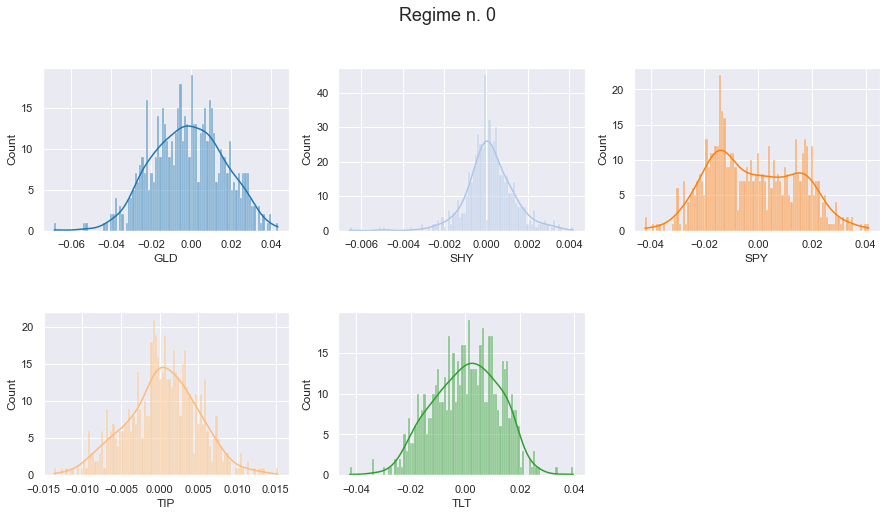

Number of observations:  566


In [12]:
plot_r(res_train,0)

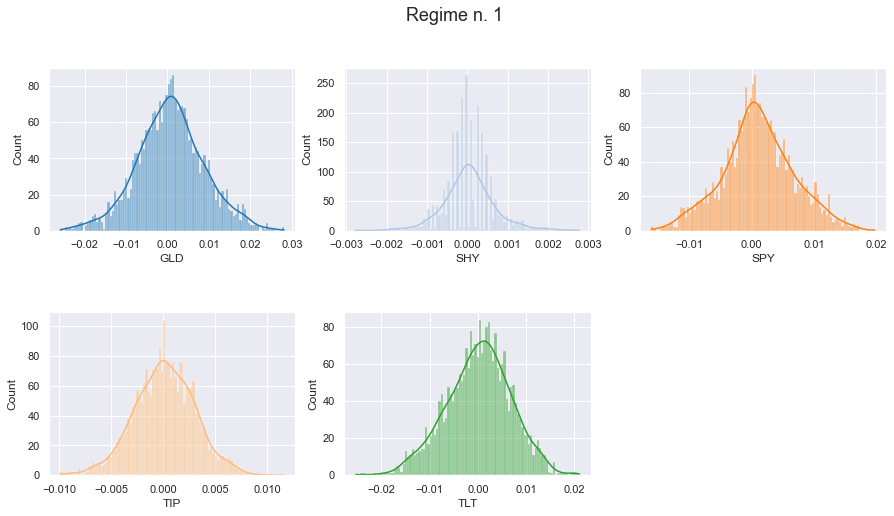

Number of observations:  2539


In [13]:
plot_r(res_train,1)

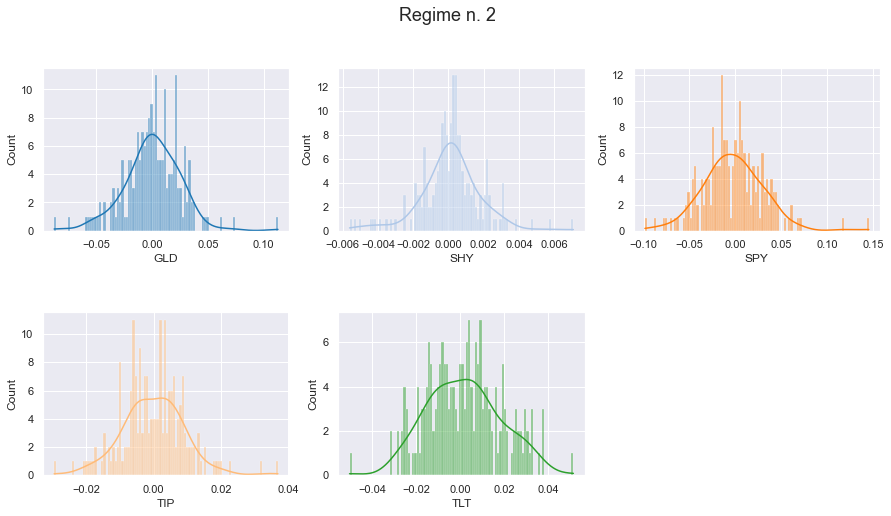

Number of observations:  197


In [14]:
plot_r(res_train,2)

# 2. Trend filtering algorithm

\begin{equation*} 
    \hat{\beta} = \text{argmin}_{\beta \in \mathbb{R}^n} ||x-\beta||_2^2 + \lambda||D\beta||_1 .
\end{equation*}

Where:
$
D =
    \begin{bmatrix}
       1 & -1 & 0 & \dots & 0 & 0  \\
       0  & 1 &-1 & \dots & 0 & 0 \\
       \vdots \\
       0  & 0 & 0 & \dots & -1 & 0\\
       0  & 0 & 0 & \dots & 1 & -1
    \end{bmatrix}
\in \mathbb{R}^{(n-1)\times n}
$

In [15]:
def trend_filtering(data,lambda_value):
    
    n = np.size(data)
    x_ret = data.reshape(n)

    Dfull = np.diag([1]*n) - np.diag([1]*(n-1),1)
    D = Dfull[0:(n-1),]

    beta = cp.Variable(n)
    lambd = cp.Parameter(nonneg=True)

    def tf_obj(x,beta,lambd):
        return cp.norm(x-beta,2)**2 + lambd*cp.norm(cp.matmul(D, beta),1)

    problem = cp.Problem(cp.Minimize(tf_obj(x_ret, beta, lambd)))

    lambd.value = lambda_value
    problem.solve()

    return beta.value

In [60]:
def regimes(x,lv,plot=True,filtering=True):
    if filtering:
        ptrain=pd.DataFrame(model.predict_proba(x),index=x.index)
        betas={}
        for i in re:
            betas[i]=trend_filtering(ptrain[i].values,lambda_value=lv)
        ss=pd.DataFrame.from_dict(betas).set_index(x.index).idxmax(axis=1)
    else:
        ss=pd.DataFrame(model.predict(x),index=x.index)

    if plot==True:
        plot_regimes(tickers,x,ss)

    return ss


In [70]:
def plot_regimes(tickers,x,ss):
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    
    for n, a in enumerate(tickers):
        
        ax = plt.subplot(3, 3, n + 1)
        y=(x[[a]]+1).cumprod()
        y['state']=ss
        for i in re:
            palette = sns.color_palette('tab20', len(re))
            plt.scatter(y=y[y['state']==i].drop('state',axis=1),x=y[y['state']==i].drop('state',axis=1).index,color=palette[i],linewidths=0.1,label=i)
        ax.set_title(a)
    
    plt.legend()
    plt.show()

### Without trend filtering

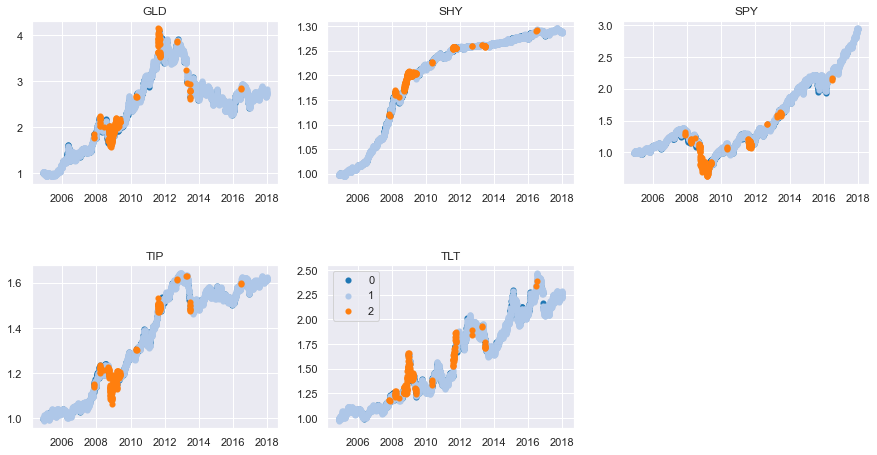

In [69]:
r_train=regimes(train,10,filtering=False)

### With trend filtering

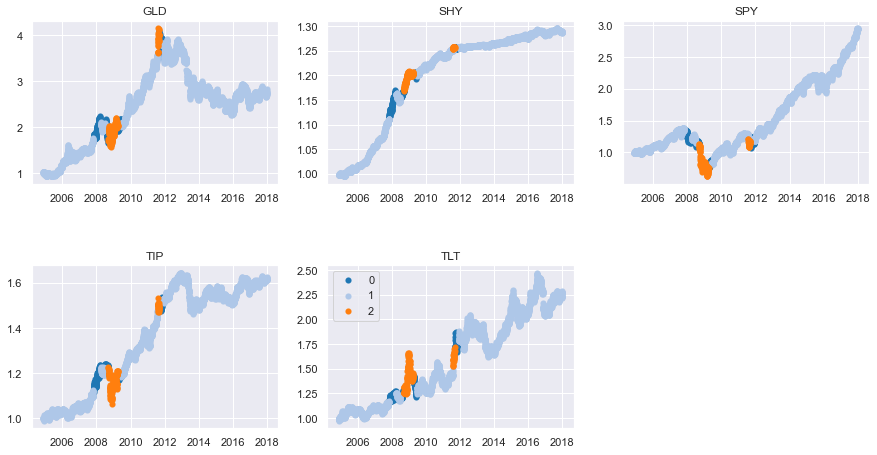

In [72]:
r_train=regimes(train,10,filtering=True)

In [19]:
res_train=train.copy()
res_train['state']=r_train
res_train.dropna(inplace=True)

<AxesSubplot:xlabel='state'>

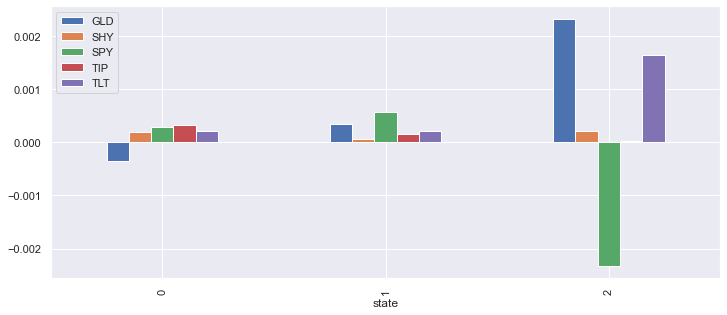

In [20]:
res_train.groupby('state').mean().plot.bar()

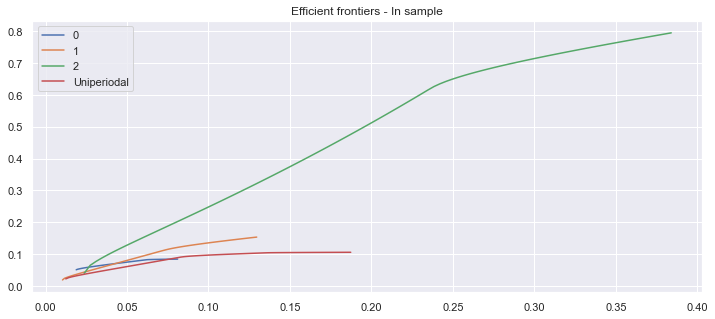

In [21]:
for i in re:
    port=rp.Portfolio(returns=res_train[res_train['state']==i].drop('state',axis=1))
    port.assets_stats(method_mu='hist', method_cov='hist')
    frontier = port.efficient_frontier(model='Classic', points=100)

    yy=[]
    for a, b in frontier.iteritems():
        yy.append((float((b@port.mu.T+1)**(252)-1),np.sqrt(np.dot(b.T,np.dot(port.cov,b))*(252))))

    a=pd.DataFrame(yy,columns=['Mean','STD']).set_index('STD')

    plt.plot(a,label=i)

port=rp.Portfolio(returns=res_train.drop('state',axis=1))
port.assets_stats(method_mu='hist', method_cov='hist')
frontier = port.efficient_frontier(model='Classic', points=100)
yy=[]
for a, b in frontier.iteritems():
    yy.append((float((b@port.mu.T+1)**(252)-1),np.sqrt(np.dot(b.T,np.dot(port.cov,b))*(252))))
a=pd.DataFrame(yy,columns=['Mean','STD']).set_index('STD')

plt.plot(a,label='Uniperiodal')

plt.title('Efficient frontiers - In sample')
plt.legend()
plt.show()

## Out of sample

In [22]:
res_test=test.copy()

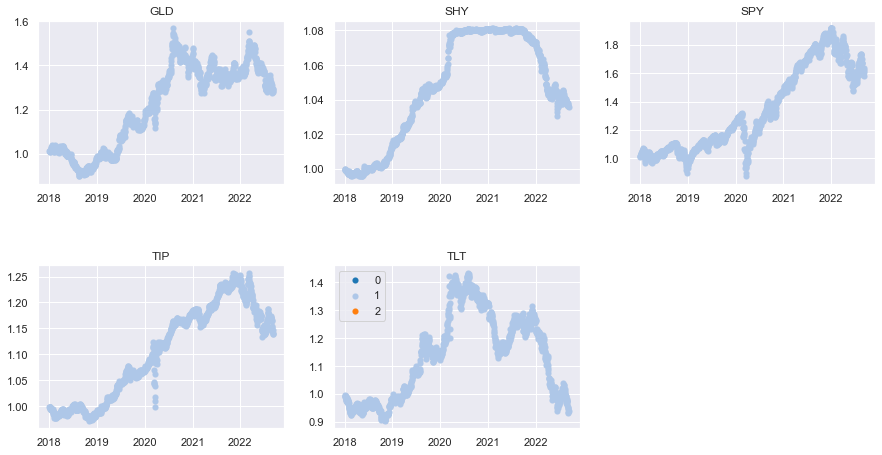

In [23]:
r_regimes=regimes(test,20)

## 2.1 Preventing Look Ahead bias

In [24]:
from tqdm import tqdm

In [25]:
d=[]
for i in tqdm(range(100,len(test),1)):
    d.append(test.iloc[i].name)

100%|██████████| 1081/1081 [00:00<00:00, 12356.09it/s]


Execute GHMM classification & tend filtering every five trading day to prevent look ahead bias:

In [26]:
a=[]
for i in tqdm(range(100,len(test),1)):
    a.append(regimes(test.iloc[i-100:i], 20, plot=False)[-1])

100%|██████████| 1081/1081 [01:21<00:00, 13.24it/s]


In [27]:
r_test=pd.DataFrame(a,index=d)

In [28]:
res_test['state']=r_test.resample('D').ffill()

<AxesSubplot:>

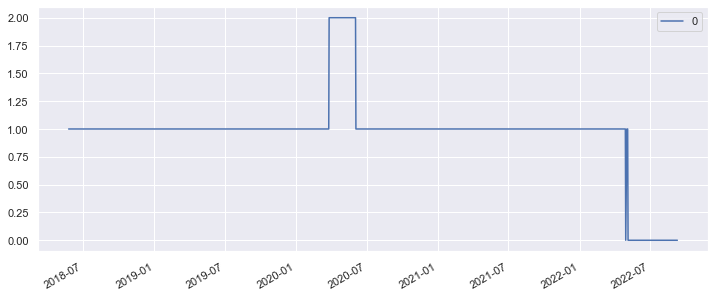

In [29]:
r_test.plot()

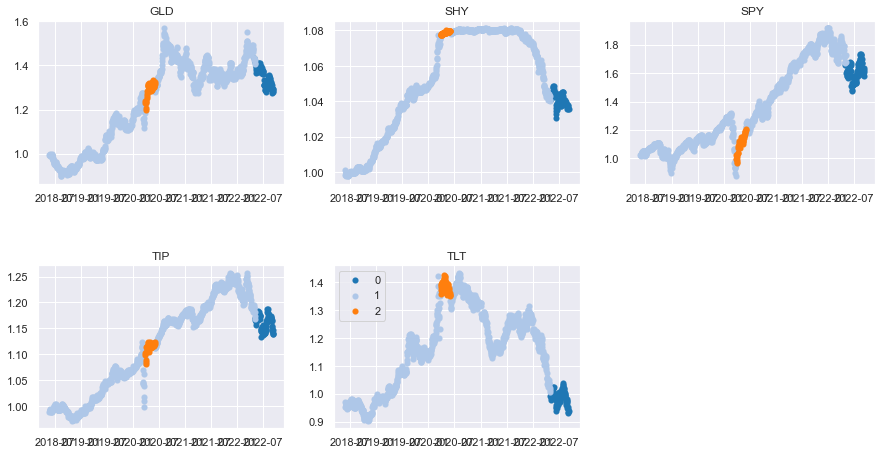

In [30]:
plot_regimes(tickers,res_test.drop('state',axis=1),r_test)

## Functions

In [31]:
def backtest_rebal(rets,weights,index_,taxes=0.26):
    index_.append(len(rets)-1)
    first=True
    a=pd.Series()
    c=0
    x=0
    for i in index_:
        if first==True:
            first=False
        else:
            a=pd.concat([(rets.iloc[x:i]@np.array(weights.iloc[c])),a],join='inner')
            c+=1
        x=i

    a.sort_index(inplace=True)

    hist=(a+1).cumprod()

    return hist

In [32]:
def backtest(X):
    hist=[]
    for i in states:
        hist.append(test.iloc[ema-1:][res_test['state']==i]@X.loc[i])
    y=(pd.concat(hist).sort_index()+1).cumprod()
    return y

# 3. Optimization

In [33]:
def estimates(Y):
    mu=(Y+1).prod()**(252/len(Y))-1
    sigma=Y.cov()*(252**0.5)
    return mu, sigma

### Rebalancing dates

In [34]:
def rebaldates(rets,n_loockback=250,n_rebal=1):
    index = rets.groupby([rets.index.year, rets.index.month]).tail(1).index
    index_2 = rets.index
    index = [x for x in index if float(x.month) % n_rebal== 0 ] 
    index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > n_loockback]

    return index_,index


In [35]:
def opt(Y,model,l=4,rm='MV'):
    port=rp.HCPortfolio(Y)
    w=port.optimization(model='NCO',obj='Utility',covariance='fixed',l=l,rm=rm)
    return w

In [36]:
returns1=pd.concat([res_test,res_train]).sort_index().dropna()

def optimization(returns1,model,rm='MV',l=6):
    weights = pd.DataFrame([])
    dates,index=rebaldates(returns1)
    first=True
    ok=False
    d=[]
    for i in dates:
        state=returns1.iloc[i]['state']
        if first==True:
            ok=True
            first=False
        else:
            if state!=state1:
                ok=True
            else:
                ok=False
        if ok:
            Y=returns1[returns1['state']==state].drop('state',axis=1)
            w=opt(Y,model,rm=rm,l=l)
            weights = pd.concat([weights, w], axis = 1)
            d.append(str(returns1.iloc[i].name))
        state1=state
        
    r_dates=[returns1.index.get_loc(x) for x in list(returns1.loc[d].index)]
    weights=weights.T
    weights.index=d
    hist=backtest_rebal(returns1.drop('state',axis=1),weights,r_dates) 


    return weights,hist

## RBAA
### Mean Variance

$$
\begin{array}{ll}
\max _{w} & R(w)-\lambda \phi_{k}(w) \\
\end{array}
$$

where
* $\lambda$ is the risk adversion parameter which, in this analysis, will be 6 and 10
* $\phi$ is is the risk measure, we will consider the variance in this notebook
* $R(w)$ is the expected portfolio return

In [37]:
weights={}
hists={}
l=[2,6,10,14]
print(l)
for i in l:
    weights[i],hists[i]=optimization(returns1,model='MV',rm='MV',l=i)

[2, 6, 10, 14]


In [38]:
import matplotlib.dates as mdates

def plot_weights(weights):
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    for n, a in enumerate(l):
        ax = plt.subplot(3, 3, n + 1)
        df=pd.DataFrame(weights[a])
        df.index=pd.to_datetime(df.index)
        pd.DataFrame(df).plot.bar(stacked=True,ax=ax,legend=False)
        ax.set_xticklabels(df.index.strftime('%Y-%m'))
        plt.title('Risk adv. factor: '+str(a))
    plt.legend()
    plt.show()

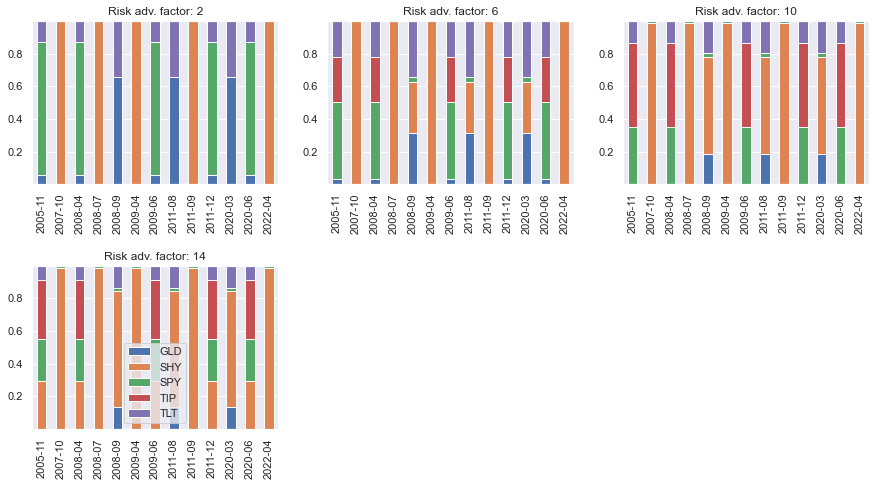

In [39]:
plot_weights(weights)

## Uniperiodal

In [40]:
def uniperdiodal_backtest(w,returns):
    hist=(returns@w+1).cumprod()
    return hist

## Other functions

In [41]:
def drawdown(x):
    running_max = np.maximum.accumulate(x)
    dd = x / running_max - 1 
    return dd

In [42]:
def computestats(x):
    std=x.pct_change().dropna().std()*(252**0.5)
    cagr=(x[-1]/x[0])**(252/len(x))-1
    sharpe=cagr/std
    neg_std=(x.pct_change()[x.pct_change() < x.pct_change().mean()].std())*(252**0.5)
    sortino=(cagr)/ neg_std
    dd=drawdown(x).min()
    return cagr,std,sharpe,sortino,dd

# 4. Backtest

In [43]:
def split(hist,x=split_date,differ=100,scale=True,std=0.05):
    hist=(hist.loc[x:])
    hist=hist.iloc[differ:]
    if scale:
        h_std=hist.pct_change().dropna().std()*(252**0.5)
        h_pct=hist.pct_change()*(std/h_std)
        hist=(1+h_pct).cumprod()
    else:
        hist=(1+hist.pct_change()).cumprod()
    hist.iloc[0]=1
    return hist

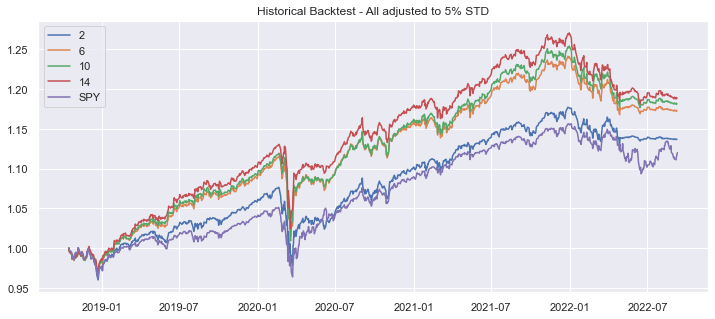

In [44]:
for i in l:
    plt.plot(split(hists[i],scale=True),label=i)
plt.plot(split(data['SPY'],differ=200,scale=True),label='SPY')
plt.legend()
plt.title('Historical Backtest - All adjusted to 5% STD')
plt.show()

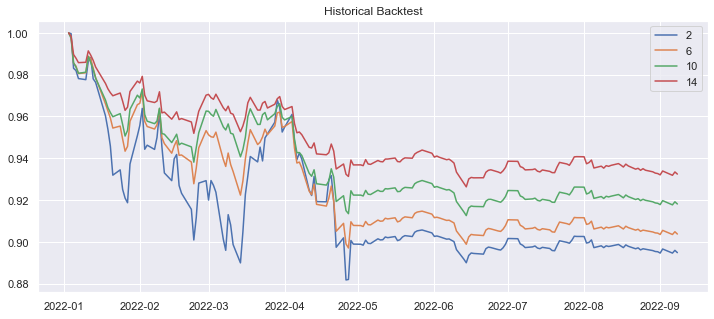

In [45]:
for i in l:
    plt.plot(split(hists[i],x='2022',differ=0,scale=False),label=i)
plt.legend()
plt.title('Historical Backtest')
plt.show()

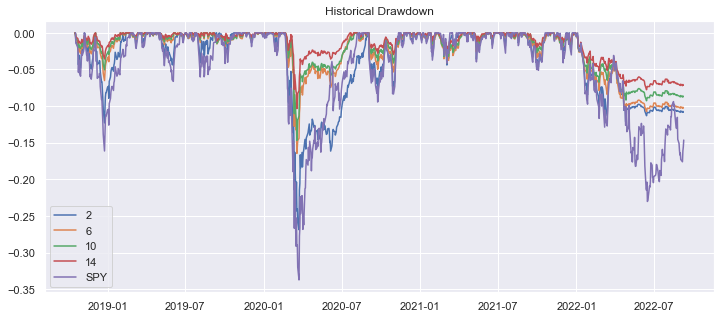

In [46]:
for i in l:
    plt.plot(drawdown(split(hists[i],scale=False)),label=i)
plt.plot(drawdown(split(data['SPY'],differ=200,scale=False)),label='SPY')
plt.legend()
plt.title('Historical Drawdown')
plt.show()

# Stats

In [47]:
a=[]
for i in l:
    a.append(computestats(hists[i]))


In [48]:
results=pd.DataFrame(a,index=l,columns=['cagr','std','sharpe','sortino','dd'])
results.loc['SPY']=computestats(split(data['SPY'],differ=200,scale=False))

In [49]:
results

,cagr,std,sharpe,sortino,dd
2,0.107995,0.126535,0.853476,1.033127,-0.268697
6,0.083212,0.074463,1.117493,1.402441,-0.164480
10,0.069967,0.059181,1.182260,1.508284,-0.146735
14,0.054935,0.043286,1.269126,1.632080,-0.103371
SPY,0.117001,0.223903,0.522553,0.624153,-0.337173


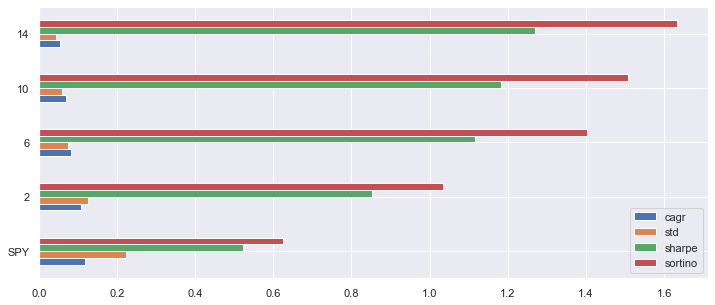

In [50]:
results.sort_values('sharpe').drop('dd', axis=1).plot.barh()
plt.show()

<AxesSubplot:title={'center':'|Max DD|/CAGR'}>

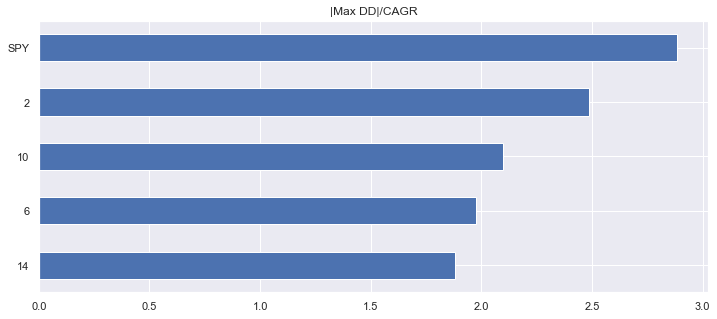

In [51]:
(-results['dd']/results['cagr']).sort_values().plot.barh(title='|Max DD|/CAGR')

# Further work

Below is reported the necessary further work to make this empirical experiment complete:
* Violate capital market assumptions, introducing transaction and slippage costs
* Extend the analysis with longer timeseries
* Introduce a Constant proportion portfolio insurance
* Consider the impact on taxes and its implication for retail investors